# Credit card fraud detection

This data was taken from the Kaggle dataset linked below. It contains a set of credit card transactions made in September 2013 by European cardholders, flagged as either genuine transactions from the cardholder or as a fraudulent transaction.

The objective is to correctly classify whether a transaction is fraudulent or not, by training classification models on the target variable Class. We have 28 anonymised variables which are the result of a PCA transformation; unfortunately we do not have any background information on the original features. We also have the columns 'Time' (defined as time of the transaction in seconds since the first recorded transaction) and 'Amount' (the amount involved in the transaction).

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Load data and libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [46]:
df = pd.read_csv('creditcard.csv')

In [47]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Initial data checks

#### Drop duplicate values

Duplicate records with identical values will not give us any additional information, so we will discard these

In [48]:
initial_no=df.shape[0]
print("Number of records: ",initial_no)
df.drop_duplicates(inplace=True)
print(initial_no-df.shape[0],"records with identical data removed")
print("Number of records after removing duplicates: ",df.shape[0])

Number of records:  284807
1081 records with identical data removed
Number of records after removing duplicates:  283726


#### Check for missing data

Check to see if we have any columns with missing data, in which case we need to consider removing any rows/columns or imputing missing values

In [27]:
df.isnull().sum()/len(df)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

Thankfully no records have missing data

#### Check class balance

Text(0.5, 1.0, 'Frequency of fraud in data')

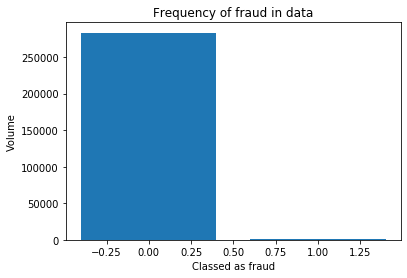

In [28]:
plt.bar(df['Class'].unique(),df['Class'].value_counts().values,width=0.8)
plt.xlabel('Classed as fraud')
plt.ylabel('Volume')
plt.title('Frequency of fraud in data')

In [29]:
df['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

We can see that the dataset is very imbalanced - only 0.17% of the transactions in the dataset were fraudulent. This will mean that when training our model we will have to optimise for a metric other than accuracy, as this will give misleading results (it will likely predict all cases negative). We may also consider rebalancing in the training dataset, by reducing the number of non-fraud cases or resampling fraud cases so that the two classes are closer in volume.  

## Exploratory data analysis

In [30]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


We've been told that the V1-V28 variables have been generated by PCA, and we don't have any information about the data in the original features. 

The two other variables not generated by PCA are the 'Time' and 'Amount' columns. 

#### Time column

Time is measured in seconds from the first observation in the dataset. We can see from the describe summary above that the latest record is 172,792 seconds after this. So the observations are distributed over a period of 48 hours. We don't want to use the time column in its raw form (as it won't generalise to future data) but we might be able to extract information  on times of the day fraud is more likely to take place. 

We can express each observation in terms of where it falls in a 24 hour (86,400 seconds) cycle period, with the first observation defining when this period starts. Whilst this dataset doesn't contain the time of day that this first observation was made in, we could assume in real life that it would be available (and the start and end of the 24 hour cycle period would be known, or we could express observations in standard time on a 24-hour clock). We'll see below that when we look at the distribution plot, we might also be able to backsolve the starting point (based on intuition of how we'd expect transactions to be distributed throughout the day). 

After expressing the observations in terms of distribution throughout a 24 hour period, we can also group them into blocks of time (below I've chosen to divide the day into 4 6-hour periods). 

Text(0.5, 1.0, 'Hour period')

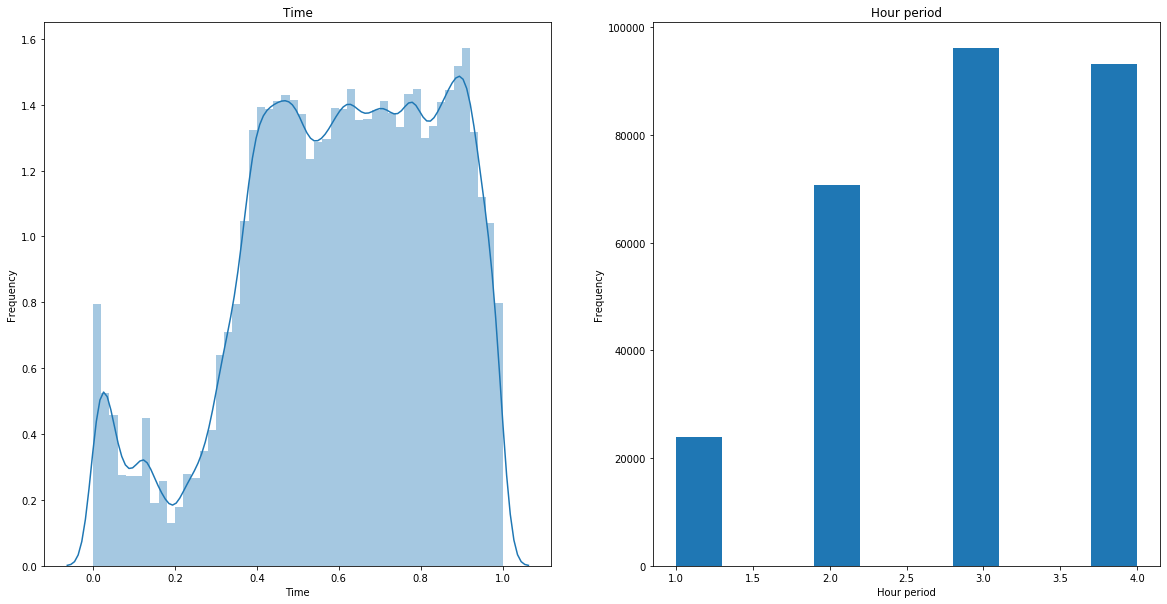

In [49]:
df['Time0to1']=(df['Time'] % 86400)/86400
df['Time6hperiod']=(df['Time0to1'] // 0.25)+1


plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.distplot(df['Time0to1'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Time')

plt.subplot(122)
plt.hist(df['Time6hperiod'], histtype='bar')
plt.xlabel('Hour period')
plt.ylabel('Frequency')
plt.title('Hour period')

#### Transaction column

Text(0.5, 1.0, 'Transaction amount')

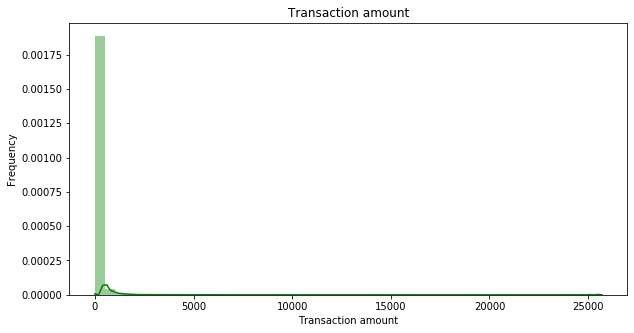

In [265]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Amount'],color='g')
plt.xlabel('Transaction amount')
plt.ylabel('Frequency')
plt.title('Transaction amount')


The data in this column appears to be strongly skewed to the right, this is likely caused by a number of transactions which are much higher than the typical range of transaction values. Skewed data can cause issues within our model, so we apply a log transform to reduce the skewness. As there seem to be a number of transactions with zero values, we'll use a log(x+1) transformation as log(0) will give an undefined result.

In [7]:
print("Transaction amount skewness: ",df['Amount'].skew())

Transaction amount skewness:  16.978803370060476


Text(0.5, 1.0, 'Transaction amount - log scaled')

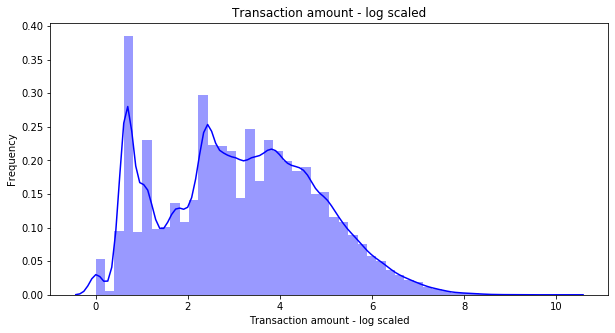

In [50]:
df['AmountLogScale'] = np.log(df['Amount']+1)

plt.figure(figsize=(10, 5))

sns.distplot(df['AmountLogScale'],color='b')
plt.xlabel('Transaction amount - log scaled')
plt.ylabel('Frequency')
plt.title('Transaction amount - log scaled')

In [51]:
print("Log transformed transaction amount skewness: ",df['AmountLogScale'].skew())

Log transformed transaction amount skewness:  0.16141018223366638


The transformation has greatly reduced the skewness. Let's check for skewness in any of the other columns.

In [31]:
skewness=[]

for column in df.drop(['Class','Amount'],axis=1).columns.tolist():
    skewness.append(df[column].skew())

columnskewness=pd.DataFrame({"Column" : df.drop(['Class','Amount'],axis=1).columns.tolist(),"Skewness":skewness})
display(columnskewness.sort_values('Skewness',ascending=False))


,Column,Skewness
28,V28,11.555115
7,V7,2.890271
21,V21,2.820033
6,V6,1.829880
10,V10,1.252967
4,V4,0.671504
26,V26,0.580292
9,V9,0.537663
11,V11,0.344074
31,AmountLogScale,0.161410


V28 also appears to be significantly skewed to the right. We can apply another log transformation on this column, however this field has negative values which have a non-defined result when passed through the log function. To avoid this we first translate the data so that all values are greater than zero, by adding the minimum value of V28 plus an arbitrary amount to all records.

In [10]:
print("V28 skewness: ",df['V28'].skew())

V28 skewness:  11.555115084196775


Log transformed V28 skewness:  0.6211597037015326


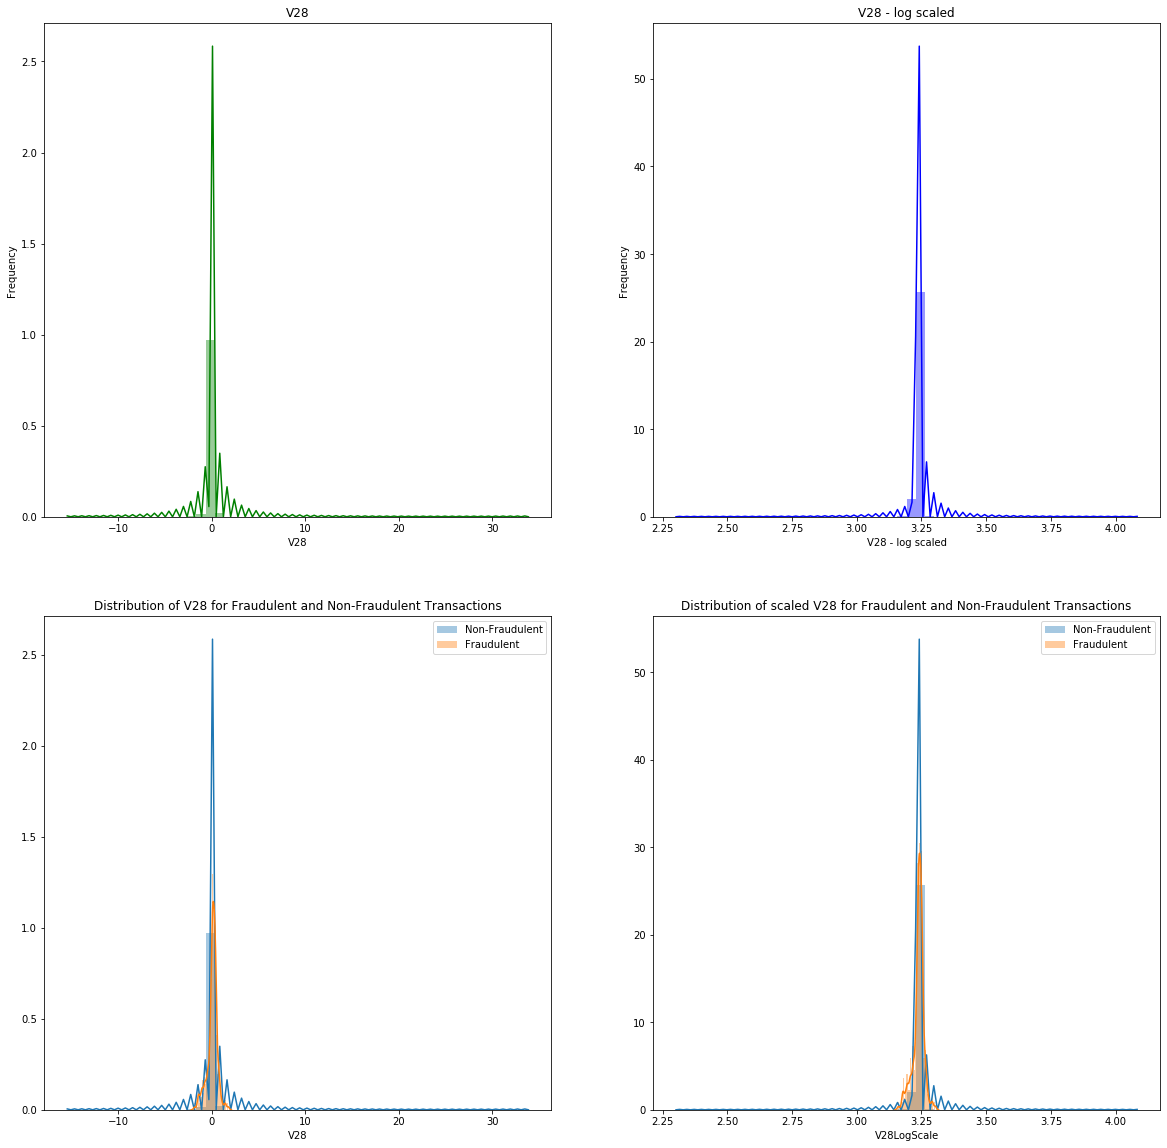

In [52]:
df['V28LogScale'] = np.log(df['V28']+abs(df['V28'].min())+10)
#df['V28LogScale'] = np.square(df['V28'])

plt.figure(figsize=(20, 20))

plt.subplot(221)
sns.distplot(df['V28'],color='g')
plt.xlabel('V28')
plt.ylabel('Frequency')
plt.title('V28')

plt.subplot(222)
sns.distplot(df['V28LogScale'],color='b')
plt.xlabel('V28 - log scaled')
plt.ylabel('Frequency')
plt.title('V28 - log scaled')

plt.subplot(223)
sns.distplot(df[df['Class']==0]['V28'])
sns.distplot(df[df['Class']==1]['V28'])
plt.legend(["Non-Fraudulent", "Fraudulent"])
plt.title('Distribution of V28 for Fraudulent and Non-Fraudulent Transactions')

plt.subplot(224)
sns.distplot(df[df['Class']==0]['V28LogScale'])
sns.distplot(df[df['Class']==1]['V28LogScale'])
plt.legend(["Non-Fraudulent", "Fraudulent"])
plt.title('Distribution of scaled V28 for Fraudulent and Non-Fraudulent Transactions')

print("Log transformed V28 skewness: ",df['V28LogScale'].skew())


V8 also has a fairly strong negative skew, we can apply a squared transformation to this variable which should reduce this

Square transformed V8 skewness:  -5.238009156330449


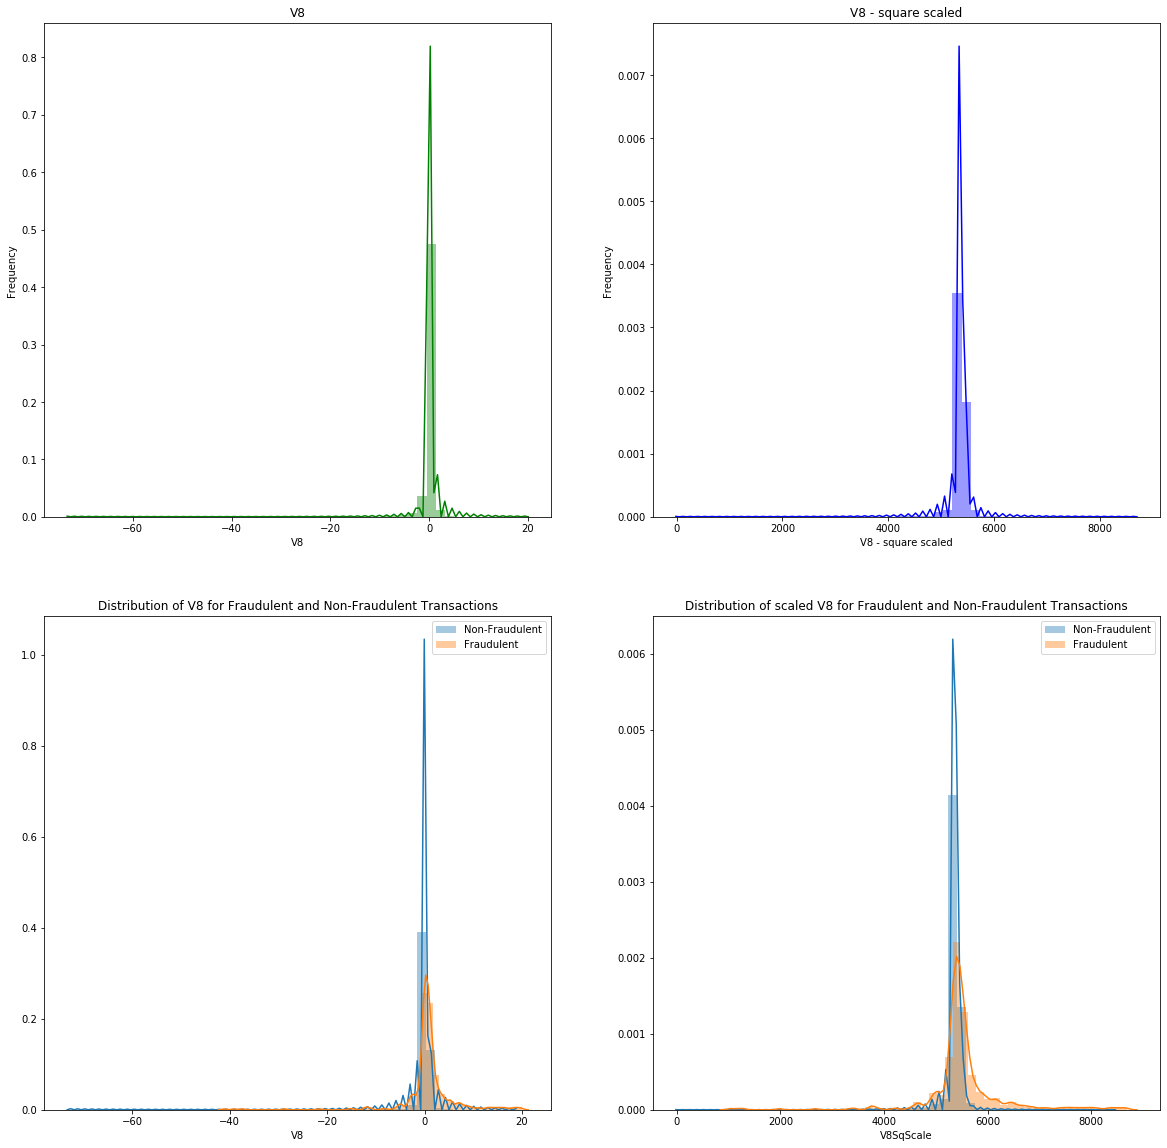

In [53]:
df['V8SqScale'] = np.square(df['V8']+abs(df['V8'].min()))

plt.figure(figsize=(20, 20))

plt.subplot(221)
sns.distplot(df['V8'],color='g')
plt.xlabel('V8')
plt.ylabel('Frequency')
plt.title('V8')

plt.subplot(222)
sns.distplot(df['V8SqScale'],color='b')
plt.xlabel('V8 - square scaled')
plt.ylabel('Frequency')
plt.title('V8 - square scaled')

plt.subplot(223)
sns.distplot(df[df['Class']==0]['V8'])
sns.distplot(df[df['Class']==1]['V8'])
plt.legend(["Non-Fraudulent", "Fraudulent"])
plt.title('Distribution of V8 for Fraudulent and Non-Fraudulent Transactions')

plt.subplot(224)
sns.distplot(df[df['Class']==0]['V8SqScale'])
sns.distplot(df[df['Class']==1]['V8SqScale'])
plt.legend(["Non-Fraudulent", "Fraudulent"])
plt.title('Distribution of scaled V8 for Fraudulent and Non-Fraudulent Transactions')

print("Square transformed V8 skewness: ",df['V8SqScale'].skew())

Replace the columns with the adjusted values

In [54]:
df_transformed=df.drop(['Time6hperiod','Time','Amount','V28','V8'],axis=1)
df_transformed.rename(columns={"Time0to1": "Time","AmountLogScale": "Amount", "V28LogScale": "V28","V8SqScale":"V8"},inplace=True)
df_transformed.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V23,V24,V25,V26,V27,Class,Time,Amount,V28,V8
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,0,0.000000,5.014760,3.235105,5375.150276
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0,0.000000,1.305626,3.236512,5373.156831
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,0,0.000012,5.939276,3.233580,5397.017221
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0,0.000012,4.824306,3.238347,5416.099552
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0,0.000023,4.262539,3.244358,5321.146020


Now let's explore the distribution of all the variables for fraud and non fraud cases

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

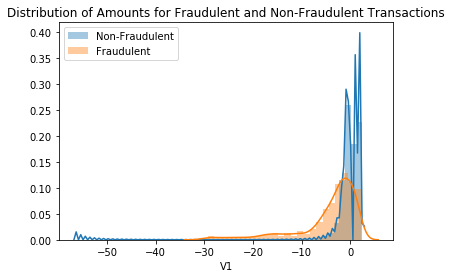

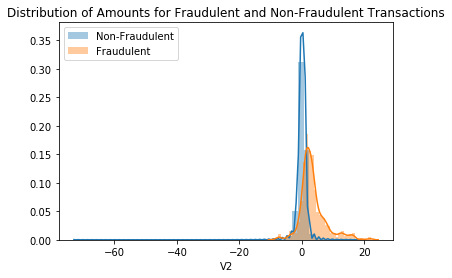

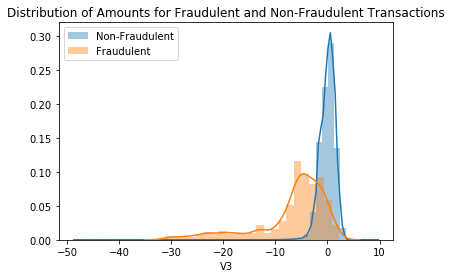

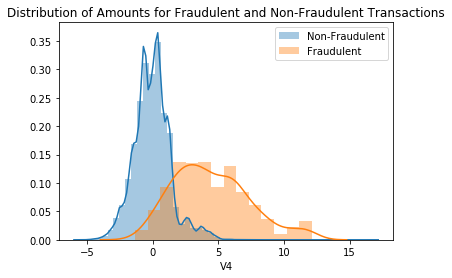

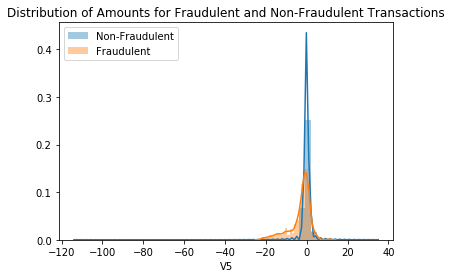

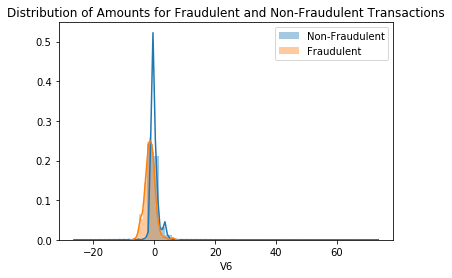

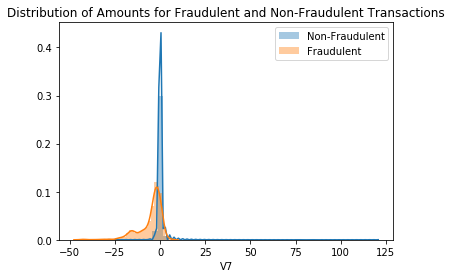

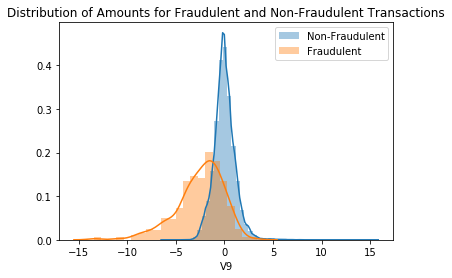

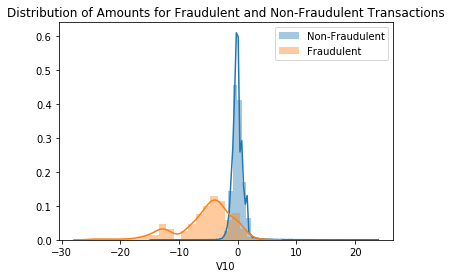

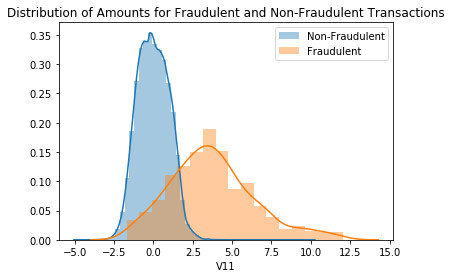

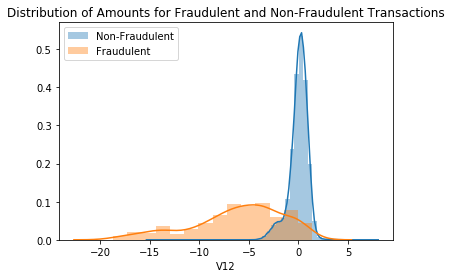

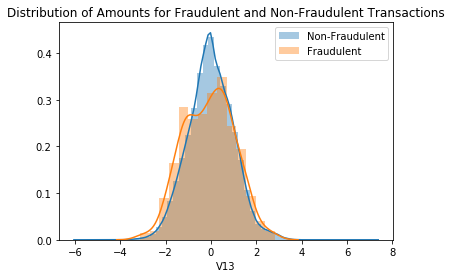

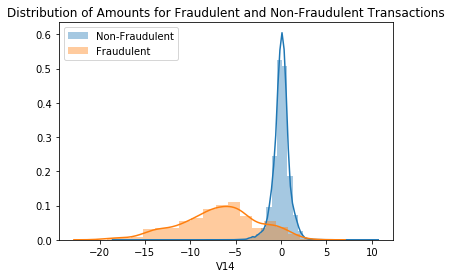

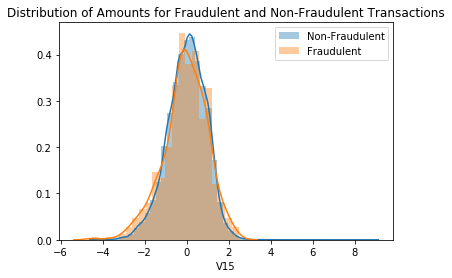

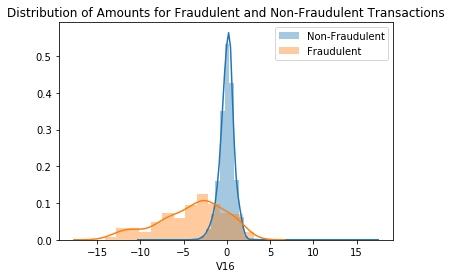

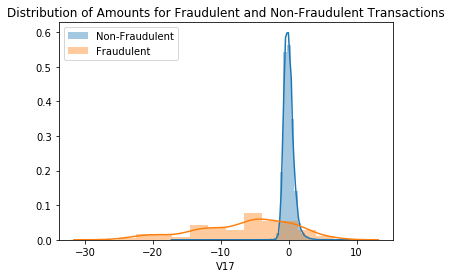

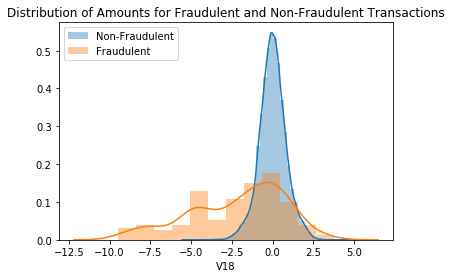

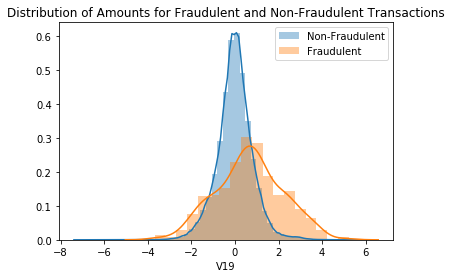

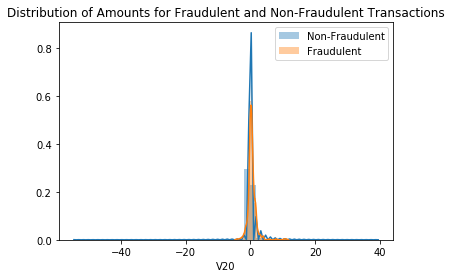

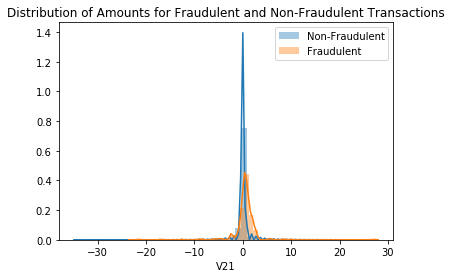

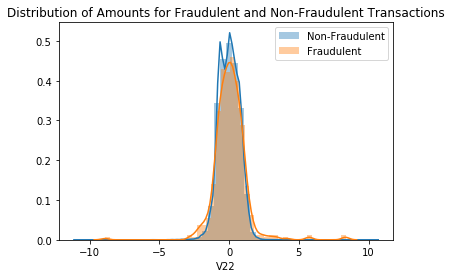

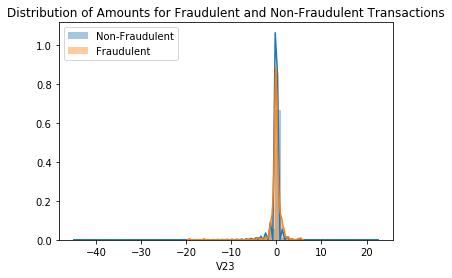

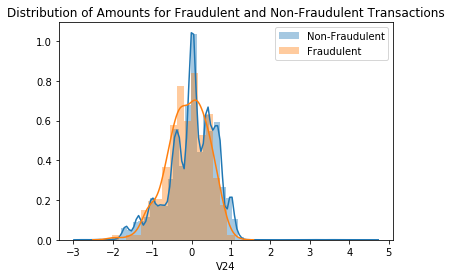

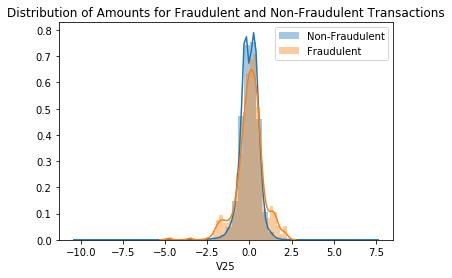

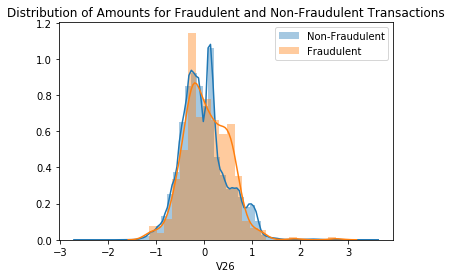

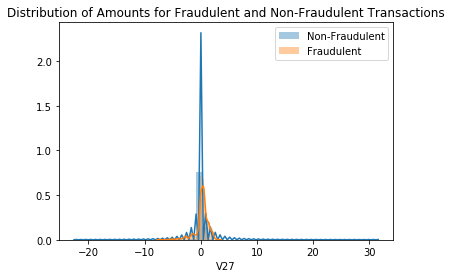

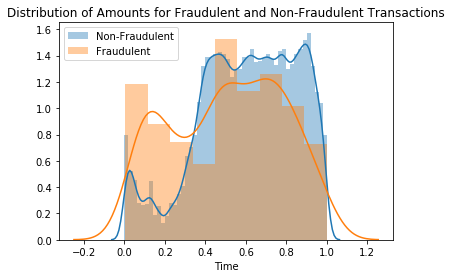

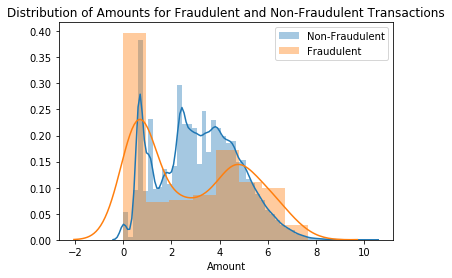

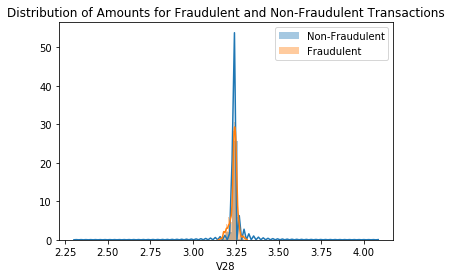

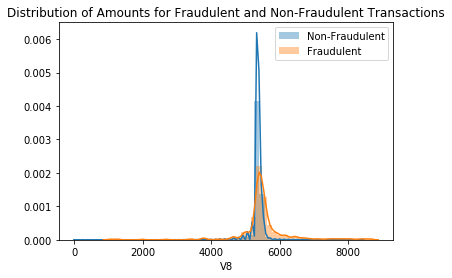

In [14]:
feature_names=df_transformed.drop(['Class'],axis=1).columns.tolist()

n = len(feature_names)

for variable in feature_names:
    plt.figure()
    sns.distplot(df_transformed[df_transformed['Class']==0][variable])
    sns.distplot(df_transformed[df_transformed['Class']==1][variable])
    plt.legend(["Non-Fraudulent", "Fraudulent"])
    plt.title('Distribution of Amounts for Fraudulent and Non-Fraudulent Transactions')

## Check for correlations & multicollinearity between variables

#### Variable correlation

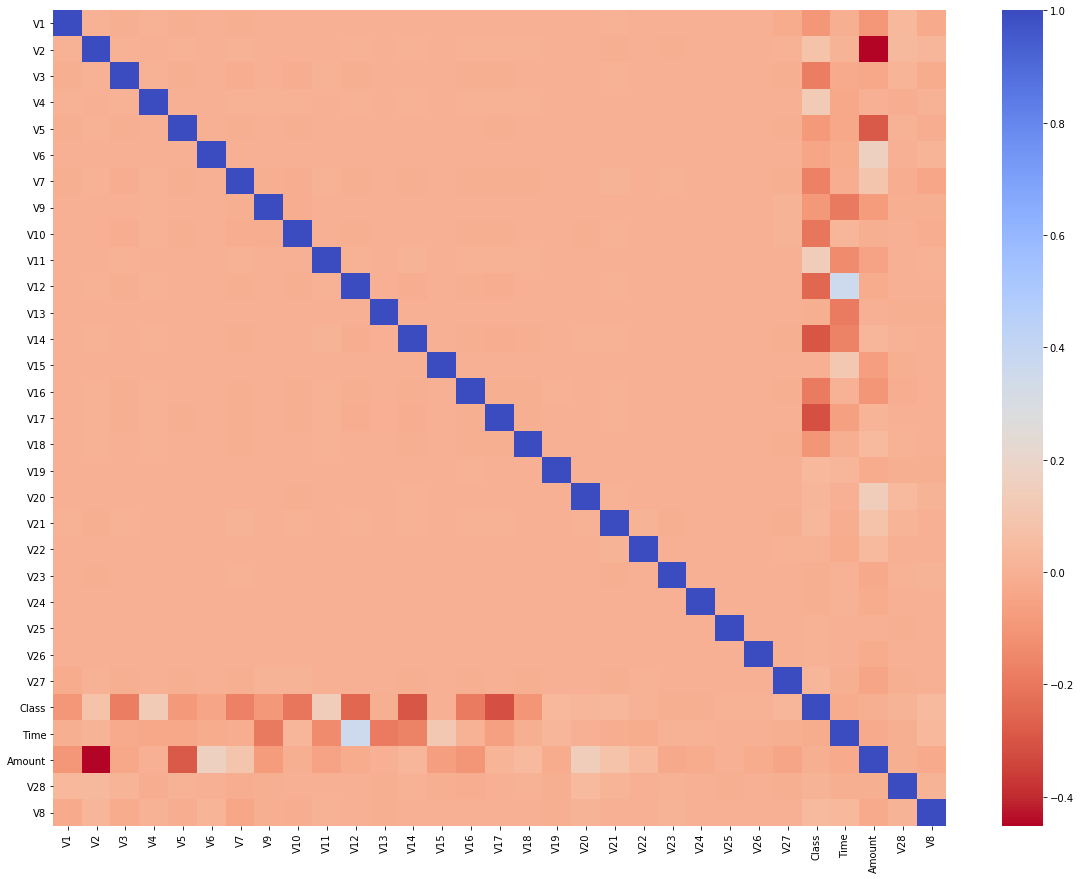

In [15]:
corr = df_transformed.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

None of the features seem to have particularly high correlation with each other. This is expected when comparing V1-V28 as we know these have been transformed by PCA.

To further check for multicollinearity, we can look at variance inflation factor.

In [16]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["variables"] = df_transformed.columns
vif["VIF"] = [variance_inflation_factor(df_transformed.values, i) for i in range(df_transformed.shape[1])]  

display(vif)

,variables,VIF
0,V1,1.038293
1,V2,1.349726
2,V3,1.081382
3,V4,1.039533
4,V5,1.156445
5,V6,1.049348
6,V7,1.088803
7,V9,1.082001
8,V10,1.099304
9,V11,1.081641


VIF seems to be extremely high for the transformed variables for some reason, so we will drop these for now.

In [142]:
df_chosenfeatures=df_transformed.drop(['V28','V8'],axis=1)
df_chosenfeatures.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V21,V22,V23,V24,V25,V26,V27,Class,Time,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,0,0.000000,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0,0.000000,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,0,0.000012,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0,0.000012,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0,0.000023,4.262539


## Balanced sample

As mentioned above, the classes in the data are extremely imbalanced and fraud cases count for a very small percentage of the dataset. In order to get a better representation of fraud cases in the training data, we will therefore attempt to rebalance by overrepresenting these fraud cases or underrepresenting genuine transactions.

#### Split into test/train datasets

We'll use a stratified split to ensure the percentage of fraud cases in test/train set is similar. As the proportion of fraud in the overall population is so small, even a random selection could generate different proportions between the train/test sets.

In [143]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df_chosenfeatures.drop('Class',axis=1)
y = df_chosenfeatures['Class']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df, df['Class']):
    X_strat_train_set, X_test = X.iloc[train_index], X.iloc[test_index]
    y_strat_train_set, y_test = y.iloc[train_index], y.iloc[test_index]
    
print("number of transactions in training data:", len(y_strat_train_set))
print("number of transactions in testing data:", len(y_test))  

number of transactions in training data: 226980
number of transactions in testing data: 56746


In [21]:
print(y_strat_train_set.sum()/y_strat_train_set.count())
print(y_test.sum()/y_test.count())

0.0016653449643140364
0.0016741268107003137


The function below will allow us to customise the balance in the dataset.

- The oversample parameter passed to resample_fraud will determine whether we are oversampling fraud cases (=1) or undersampling genuine transactions (=0).
- The rate parameters allows us to set the proportion of examples in the training data which are fraudulent.

In [57]:
def resample_fraud(X_train, y_train,oversample,rate):
    dataframe = pd.concat([X_train, y_train], axis=1)
    
    if oversample==1:
        fraud_indices = dataframe[dataframe['Class'] == 1].index.tolist()
        non_fraud_length = len(dataframe[dataframe['Class'] == 0])
        
        resampled_fraud_indices = np.random.choice(fraud_indices, size=int(np.round(non_fraud_length*rate)), replace = True)
        resampled_fraud_rows = dataframe.loc[resampled_fraud_indices,:]

        new_dataframe = pd.concat([dataframe[dataframe['Class'] == 0], resampled_fraud_rows])
        new_dataframe = new_dataframe.sample(frac=1).reset_index(drop=True)

        return(new_dataframe, new_dataframe.drop('Class', axis=1), new_dataframe['Class'])
    
    else:
        fraud_length=len(dataframe[dataframe['Class'] == 1])
        resampled_nofraud_rows=dataframe[dataframe['Class'] == 0].sample(n=np.round(fraud_length*rate))
        
        new_dataframe = pd.concat([dataframe[dataframe['Class'] == 1], resampled_nofraud_rows])
        new_dataframe = new_dataframe.sample(frac=1).reset_index(drop=True)
        
        return(new_dataframe, new_dataframe.drop('Class', axis=1), new_dataframe['Class'])
    

We'll try underrepresenting the genuine transactions so that there is a 10 to 1 ratio between genuine and fraudulent cases. 

In [170]:
train_set_resampled, X_train, y_train = resample_fraud(X_strat_train_set, y_strat_train_set,0,10)
print("length of oversampled training data", len(train_set_resampled))
print(train_set_resampled['Class'].value_counts())

length of oversampled training data 4158
0    3780
1     378
Name: Class, dtype: int64


Check the correlations between the variables in the rebalanced training set. Due to the undersampling, these may have shifted and be more influenced by outliers due to a smaller sample size.

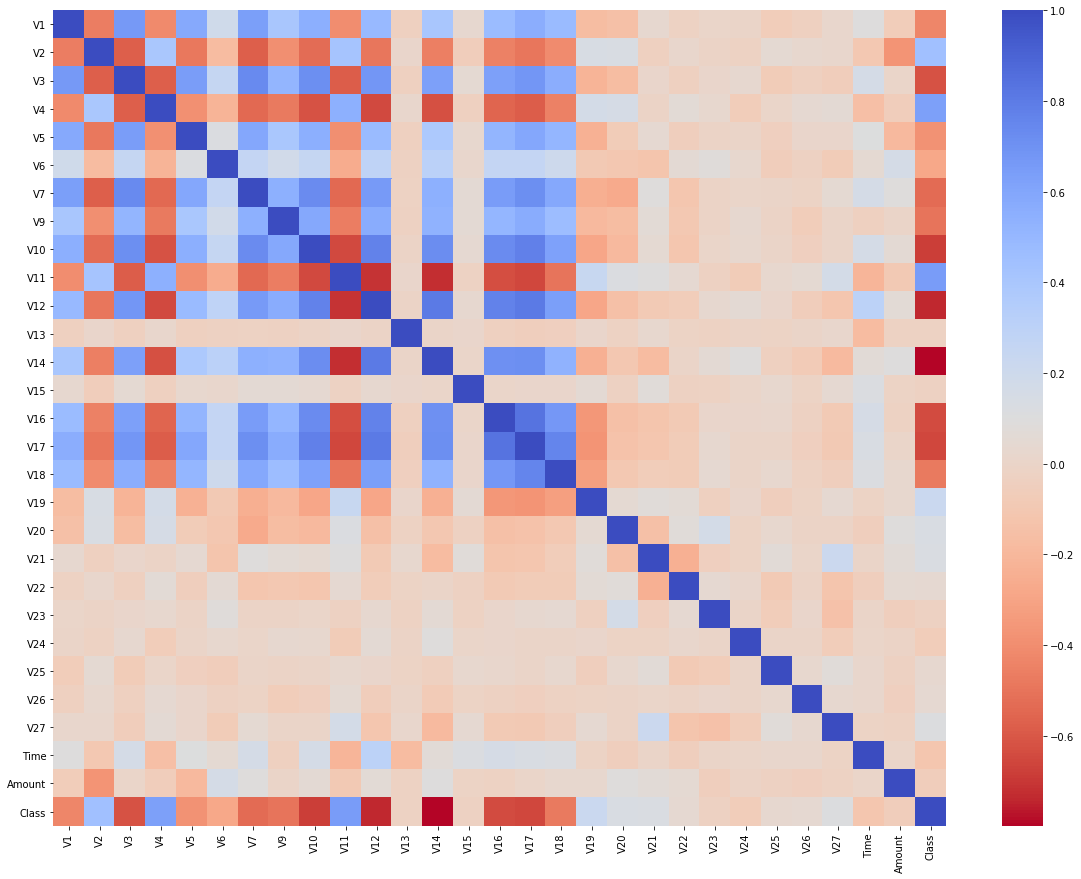

In [24]:
corr = train_set_resampled.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

#### Which variables in the training data have highest correlation with Class?

<BarContainer object of 28 artists>

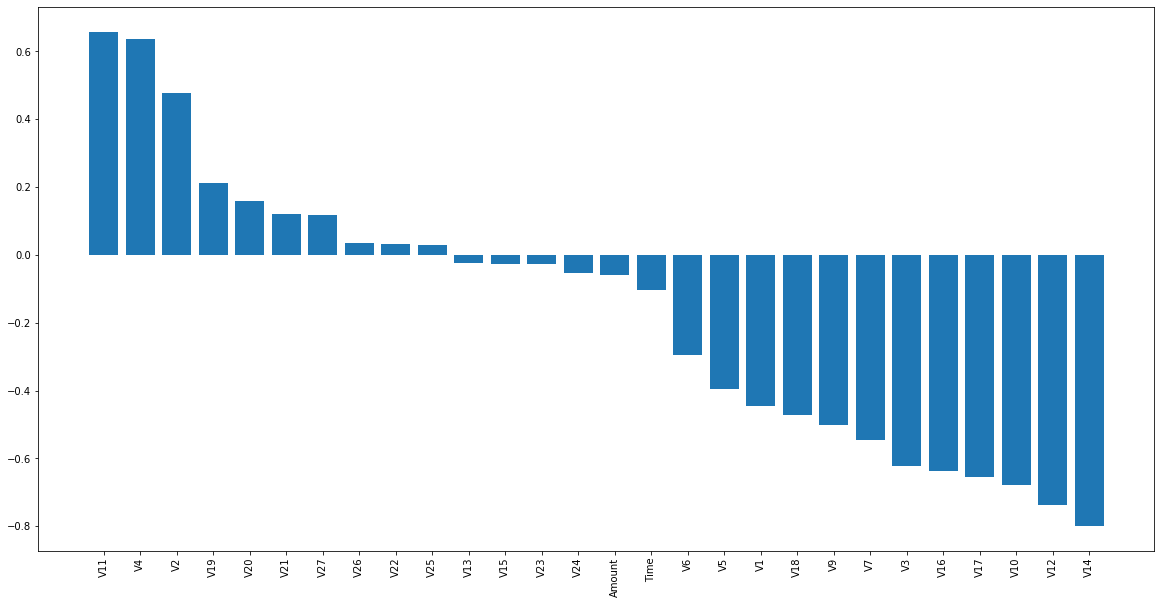

In [145]:
correlations_resampled=train_set_resampled.corr()[['Class']].drop('Class',axis=0)
correlations_resampled.reset_index(inplace=True)
correlations_resampled.sort_values('Class',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(correlations_resampled['index'],correlations_resampled['Class'],width=0.8)


In [146]:
display(correlations_resampled)

,index,Class
9,V11,0.657775
3,V4,0.636853
1,V2,0.478180
17,V19,0.211226
18,V20,0.158781
19,V21,0.120653
25,V27,0.118692
24,V26,0.035513
20,V22,0.032039
23,V25,0.029929


We can observe that:
- V11, V4 and V2 have the strongest positive correlation with 'Class' (high values indicate a higher probability that Class=1).
- V14, V12, V10, V17, V16 and V3 have the strongest negative correlation with 'Class'.


## Scale variables

In [171]:
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler 

rscaler = RobustScaler() 

X_train_scaled = pd.DataFrame(rscaler.fit_transform(X_train.values),columns=X_train.columns)
X_test_scaled = pd.DataFrame(rscaler.transform(X_test.values),columns=X_test.columns)

In [172]:
X_train_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V20,V21,V22,V23,V24,V25,V26,V27,Time,Amount
0,-0.046933,-0.369177,0.738958,-1.536576,-0.552360,-0.053136,-0.205934,-1.875294,1.055907,0.415810,...,-0.487317,-0.442162,-0.332659,0.310690,-0.085194,-0.773448,-0.991090,0.691381,0.656076,0.205402
1,0.429156,-0.478127,-0.323768,0.040434,-0.059079,-0.629674,0.751254,-0.146756,-0.057115,-0.309581,...,1.592732,0.243813,-0.231015,-1.127605,0.173028,0.744428,1.869714,-0.859714,0.522373,0.953703
2,-0.707025,-0.184056,0.009061,-0.923518,-1.039804,0.888840,-1.066056,-0.149299,0.772091,-0.227334,...,-3.069780,0.000940,0.267014,0.932215,0.237869,-1.279764,0.829976,-4.605335,0.199272,0.318751
3,-1.327660,-1.928939,0.241842,0.660530,1.070784,-1.082169,-1.198813,-0.928447,0.671581,-0.756213,...,-1.529442,-0.498163,-0.264385,-3.811371,0.113929,-0.917988,-0.884308,3.434012,0.538259,0.484570
4,-0.155425,0.937093,-0.631224,0.435528,0.961115,0.201793,0.939074,-0.667449,-0.490096,0.115760,...,0.323815,0.244348,0.296293,-0.491499,0.062434,0.087308,-0.623179,1.528138,0.464810,0.348597


In [173]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(4158, 28)
(4158,)
(56746, 28)
(56746,)


# Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression()
lrmodel.fit(X_train_scaled, y_train)

LogisticRegression()

In [175]:
predictions_train=lrmodel.predict(X_train_scaled)
display(confusion_matrix(y_train,predictions_train))

predictions=lrmodel.predict(X_test_scaled)
display(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

array([[3772,    8],
       [  52,  326]], dtype=int64)

array([[56560,    91],
       [   20,    75]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.45      0.79      0.57        95

    accuracy                           1.00     56746
   macro avg       0.73      0.89      0.79     56746
weighted avg       1.00      1.00      1.00     56746



<BarContainer object of 28 artists>

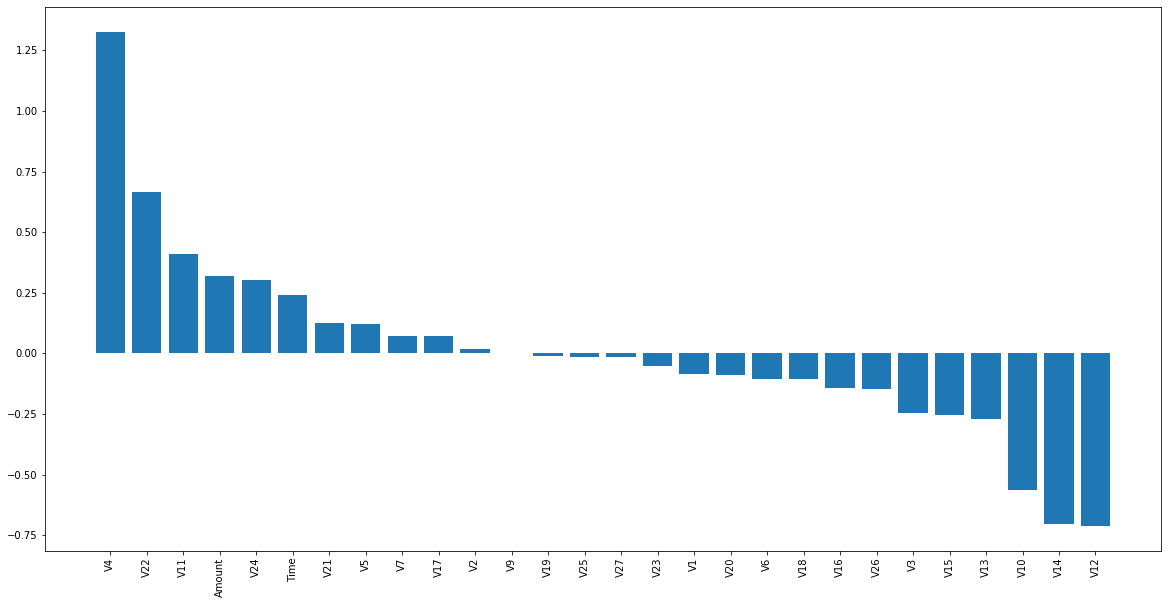

In [176]:

coefficients=pd.DataFrame({"Column" : X_train_scaled.columns.tolist(),"Coefficient":lrmodel.coef_[0].tolist()})
coefficients.sort_values('Coefficient',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(coefficients['Column'],coefficients['Coefficient'],width=0.8)

The coefficients somewhat align with our correlation analysis - V4, V11, V12, V14 and V10 are some of the most predictive variables in the model. Howevever others that had high correlation values have relatively weak coefficients in the model (such as V2).

# Random Forest

In [177]:
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [178]:
predictions_train=rfmodel.predict(X_train_scaled)
display(confusion_matrix(y_train,predictions_train))

predictions=rfmodel.predict(X_test_scaled)
display(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

array([[3780,    0],
       [   0,  378]], dtype=int64)

array([[56605,    46],
       [   20,    75]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.62      0.79      0.69        95

    accuracy                           1.00     56746
   macro avg       0.81      0.89      0.85     56746
weighted avg       1.00      1.00      1.00     56746



<BarContainer object of 28 artists>

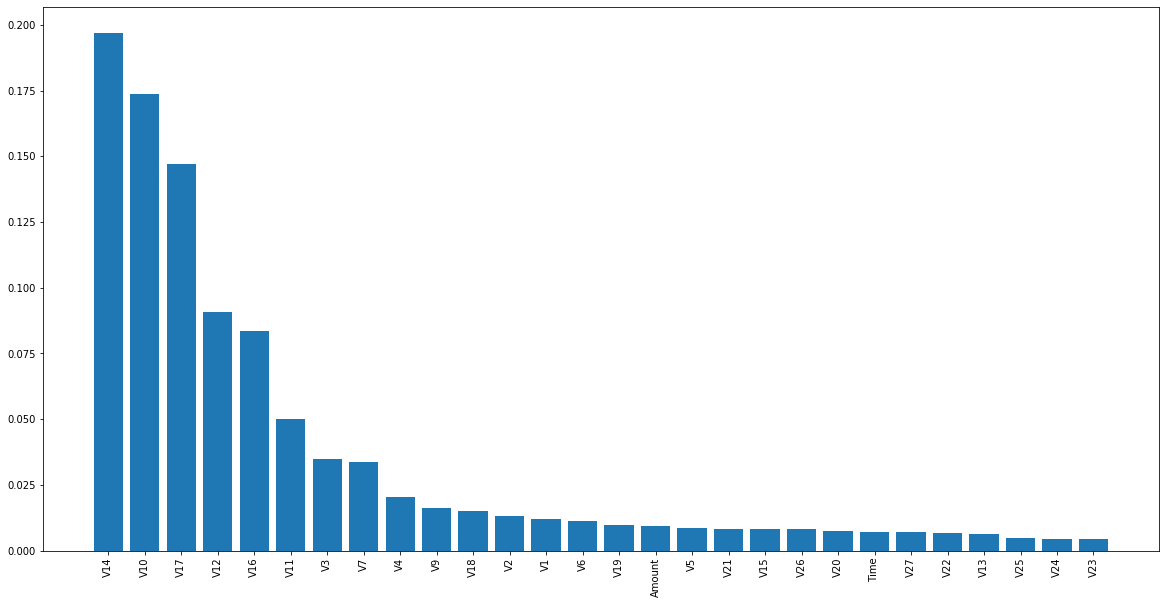

In [179]:
featureimportance = pd.DataFrame({"Column" : X_train_scaled.columns.tolist(),"FeatureImportance" : rfmodel.feature_importances_})
featureimportance.sort_values('FeatureImportance',ascending=False,inplace=True) 

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(featureimportance['Column'],featureimportance['FeatureImportance'],width=0.8)

The feature importances of the random forest model align much more with our correlation analysis - all of the most highly correlated variables we picked out (except V2) form the top 8 features with the highest importance.

## KNN Classifier

We'll also try the K-Nearest Neighbour algorithm, choosing a value of k that gives an optimal trade off between precision and recall.

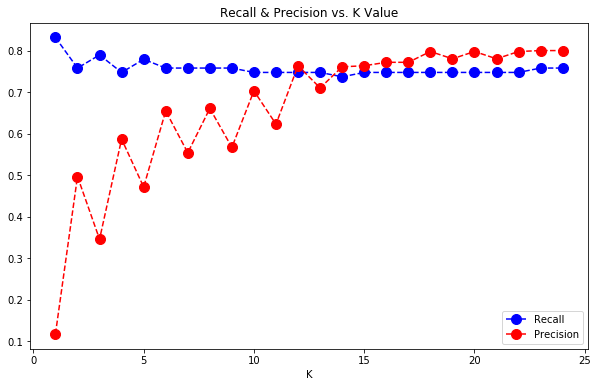

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score

knn_recall = []
knn_precision = []

for i in range(1,25):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    knn_recall.append(recall_score(y_test, pred_i))
    knn_precision.append(precision_score(y_test, pred_i))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,25),knn_recall,color='blue', linestyle='dashed', marker='o',markerfacecolor='Blue', markersize=10,label='Recall')
plt.plot(range(1,25),knn_precision,color='red', linestyle='dashed', marker='o',markerfacecolor='Red', markersize=10,label='Precision')

plt.title('Recall & Precision vs. K Value')
plt.xlabel('K')
plt.legend()


The algorithm appears to reach an optimal balance between precision and recall at around k=15

In [180]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=15)

In [181]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(4158, 28)
(4158,)
(56746, 28)
(56746,)


In [183]:
predictions_train=knn.predict(X_train_scaled)
display(confusion_matrix(y_train,predictions_train))

predictions=knn.predict(X_test_scaled)
display(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

array([[3777,    3],
       [  65,  313]], dtype=int64)

array([[56623,    28],
       [   24,    71]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.72      0.75      0.73        95

    accuracy                           1.00     56746
   macro avg       0.86      0.87      0.87     56746
weighted avg       1.00      1.00      1.00     56746



## Try removing outliers

By removing outliers, we may be able to slightly improve the performance of our machine learning algorithm. We will try this by removing fraud cases whose values for the highly correlated variables are significantly outside the normal range (above or below depending on the correlation direction).

#### Boxplot- highest positively correlated variables

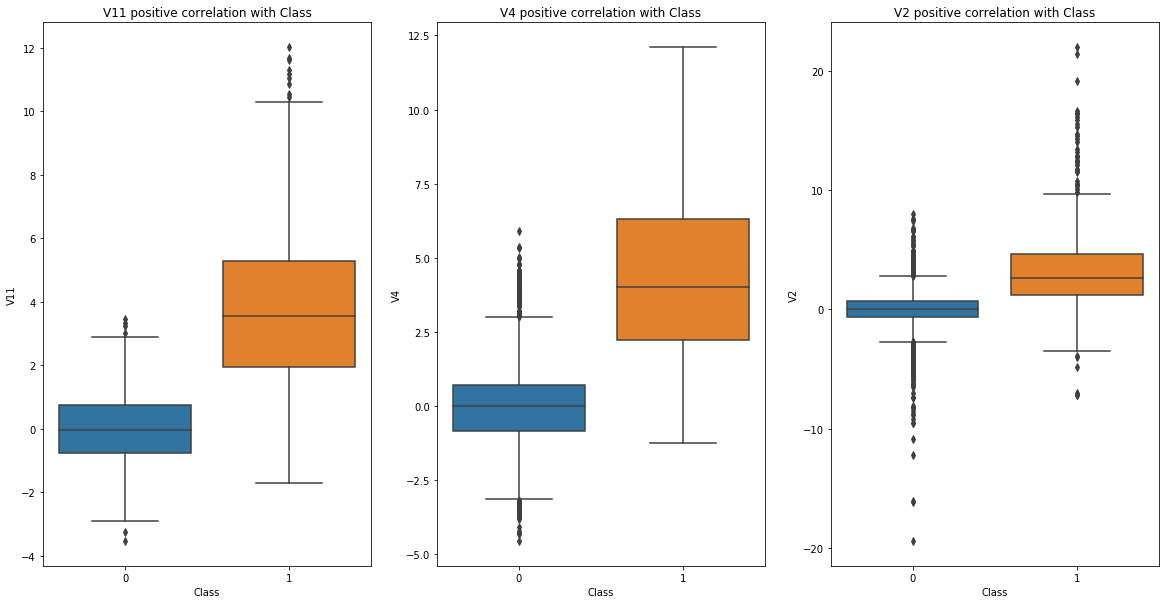

In [147]:
f, axes = plt.subplots(ncols=3, figsize=(20,10))

sns.boxplot(x="Class", y="V11", data=train_set_resampled, ax=axes[0])
axes[0].set_title('V11 positive correlation with Class')

sns.boxplot(x="Class", y="V4", data=train_set_resampled, ax=axes[1])
axes[1].set_title('V4 positive correlation with Class')

sns.boxplot(x="Class", y="V2", data=train_set_resampled, ax=axes[2])
axes[2].set_title('V2 positive correlation with Class')

plt.show()

#### Boxplot- highest negatively correlated variables

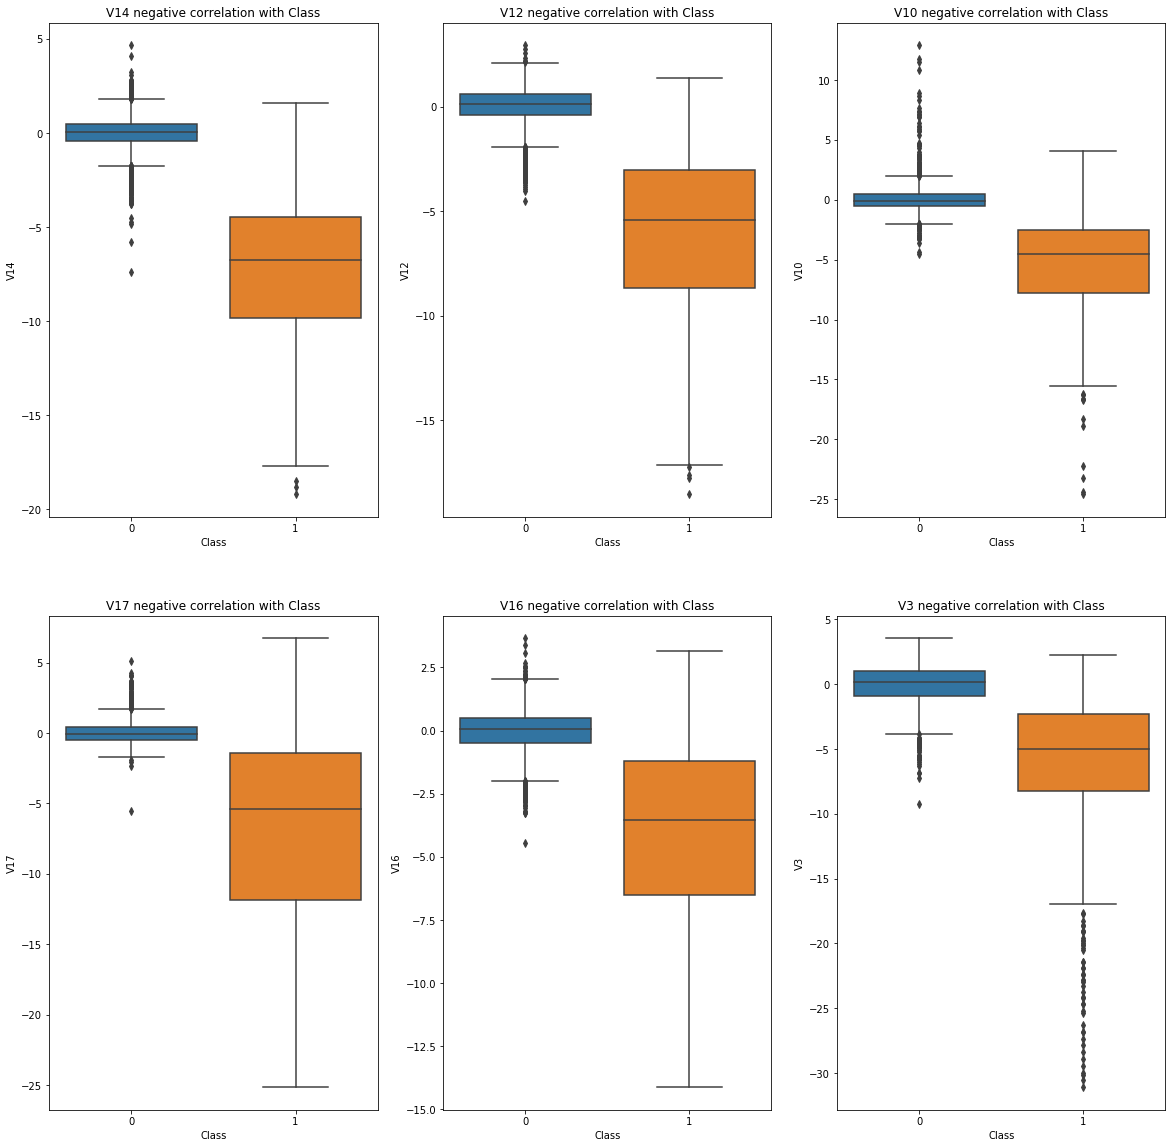

In [148]:
f, axes = plt.subplots(nrows=2,ncols=3, figsize=(20,20))

sns.boxplot(x="Class", y="V14", data=train_set_resampled, ax=axes[0,0])
axes[0,0].set_title('V14 negative correlation with Class')

sns.boxplot(x="Class", y="V12", data=train_set_resampled, ax=axes[0,1])
axes[0,1].set_title('V12 negative correlation with Class')

sns.boxplot(x="Class", y="V10", data=train_set_resampled, ax=axes[0,2])
axes[0,2].set_title('V10 negative correlation with Class')

sns.boxplot(x="Class", y="V17", data=train_set_resampled, ax=axes[1,0])
axes[1,0].set_title('V17 negative correlation with Class')

sns.boxplot(x="Class", y="V16", data=train_set_resampled, ax=axes[1,1])
axes[1,1].set_title('V16 negative correlation with Class')

sns.boxplot(x="Class", y="V3", data=train_set_resampled, ax=axes[1,2])
axes[1,2].set_title('V3 negative correlation with Class')


plt.show()

#### Find upper and lower quartiles

In [184]:
columnlist=['V11','V4','V2','V14','V12','V10','V17','V16','V3']

upperlimits=[]
lowerlimits=[]

for column in columnlist:
    fraudcases_column = train_set_resampled[train_set_resampled['Class']==1][column]
    q25, q75 = np.percentile(fraudcases_column, 25), np.percentile(fraudcases_column, 75)
    iqr=q75-q25
    lower,upper=q25-(iqr*1.5),q75+(iqr*1.5)
    upperlimits.append(upper)
    lowerlimits.append(lower)

limits=pd.DataFrame({"column":columnlist,"lower" : lowerlimits,"upper" : upperlimits})
display(limits)

,column,lower,upper
0,V11,-3.121128,10.341962
1,V4,-3.876242,12.434117
2,V2,-3.917353,9.814206
3,V14,-17.843174,3.548593
4,V12,-17.195757,5.509924
5,V10,-15.574959,5.307258
6,V17,-27.552346,14.276226
7,V16,-14.477264,6.750018
8,V3,-17.017825,6.461471


#### Remove outliers

In [185]:
train_set_removeoutliers = train_set_resampled.copy()

for column in columnlist:
    if column in ['V11','V4','V2']:
        limit=limits[limits['column']==column]['upper'].values[0]
        train_set_removeoutliers=train_set_removeoutliers[train_set_removeoutliers[column]<=limit]
    else:
        limit=limits[limits['column']==column]['lower'].values[0]
        train_set_removeoutliers=train_set_removeoutliers[train_set_removeoutliers[column]>=limit]  
        
print('Initial train set: \n')
print(train_set_resampled['Class'].value_counts())
print('After removing outliers: \n')
print(train_set_removeoutliers['Class'].value_counts())

Initial train set: 

0    3780
1     378
Name: Class, dtype: int64
After removing outliers: 

0    3780
1     322
Name: Class, dtype: int64


56 fraud cases have been removed - rerunning the correlation analysis we can see that the correlation of the variables has reduced slightly, which may reduce overfitting.

<BarContainer object of 28 artists>

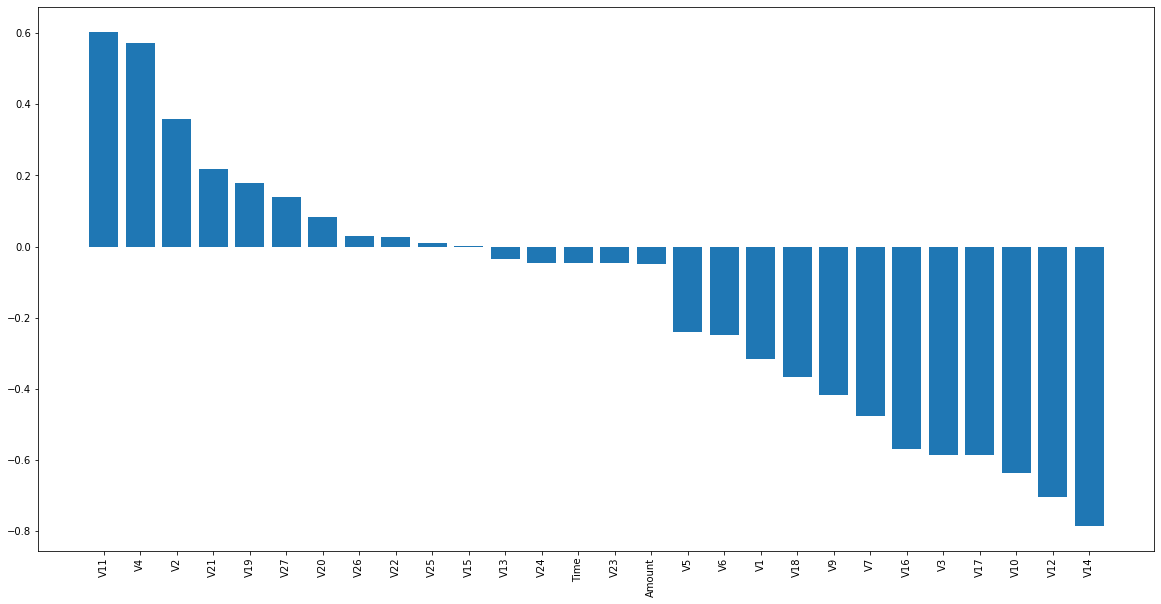

In [159]:
correlations_resampled=train_set_removeoutliers.corr()[['Class']].drop('Class',axis=0)
correlations_resampled.reset_index(inplace=True)
correlations_resampled.sort_values('Class',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(correlations_resampled['index'],correlations_resampled['Class'],width=0.8)


In [160]:
display(correlations_resampled)

,index,Class
9,V11,0.603806
3,V4,0.571395
1,V2,0.358976
19,V21,0.219324
17,V19,0.179814
25,V27,0.138749
18,V20,0.081907
24,V26,0.030102
20,V22,0.026030
23,V25,0.010998


In [186]:
X_train = train_set_removeoutliers.drop('Class',axis=1)
y_train = train_set_removeoutliers['Class']

rscaler = RobustScaler() 

X_train_scaled = pd.DataFrame(rscaler.fit_transform(X_train.values),columns=X_train.columns)
X_test_scaled = pd.DataFrame(rscaler.transform(X_test.values),columns=X_test.columns)

In [187]:
X_train_scaled.shape

(4102, 28)

#### Re-try models with outliers removed

In [188]:
lrmodel = LogisticRegression()
lrmodel.fit(X_train_scaled, y_train)

rfmodel = RandomForestClassifier()
rfmodel.fit(X_train_scaled, y_train)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=15)

In [189]:
#Confusion matrices

cm_train_lr = confusion_matrix(y_test, lrmodel.predict(X_test_scaled) , labels=[0, 1])
cm_train_rf = confusion_matrix(y_test, rfmodel.predict(X_test_scaled) , labels=[0, 1])
cm_test_km  = confusion_matrix(y_test, knn.predict(X_test_scaled) , labels=[0, 1])

Text(0.5, 1, 'KNN')

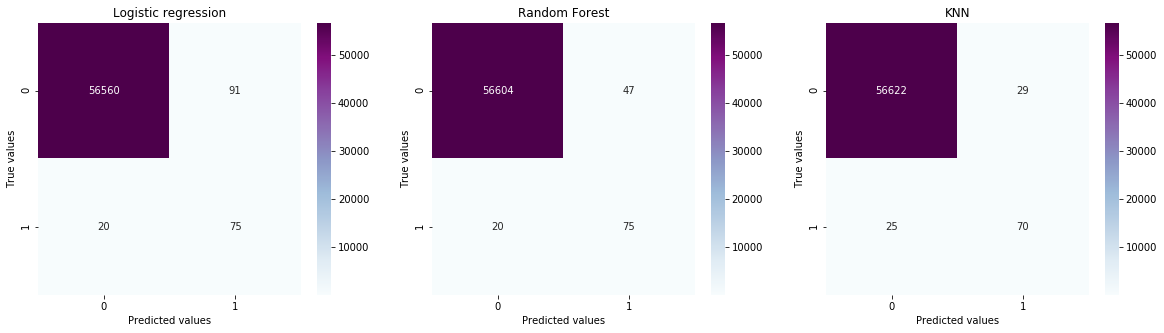

In [199]:
plt.figure(figsize=(20,5))

plt.subplot(131)
sns.heatmap(cm_train_lr, annot=True,cmap="BuPu",fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Logistic regression')

plt.subplot(132)
sns.heatmap(cm_train_rf, annot=True,cmap="BuPu",fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest')

plt.subplot(133)
sns.heatmap(cm_test_km, annot=True,cmap="BuPu",fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('KNN')

Removing outliers of the most predictive variables does not appear to change performance, so we will revert to using all the data points.

## Try model permutations

To try and find the best model, I have written the code below which will cycle through several permutations of models. The variables used, resampled ratio, scaler type and algorithm will be varied. The precision, recall and specificity of each permuation will be recorded.

This will take a while to run but helps find the best model!

#### Variables used

- Select all variables (keep V28,V8 and amount in the original format, without log/square transformation)
- Select all variables (keep V28 and V8 in the original format, without log/square transformation)
- Select all variables (use transformed versions of V28,V8 and Amount)
- Only use the strongest predictor variables based on the models trained so far

#### Resampling

- Undersample non-fraud transactions in training data to be 10x the number of fraud transactions.
- Undersample non-fraud transactions in training data to be 5x the number of fraud transactions.
- Undersample non-fraud transactions in training data to be equal to the number of fraud transactions.
- Oversample fraud transactions in training data to be 1/10 the number of non-fraud transactions.
- Oversample fraud transactions in training data to be 1/5 the number of non-fraud transactionss.
- Oversample fraud transactions in training data to be equal to the number of non-fraud transactions.

#### Scale Type

- Robust scaler
- Standard scaler

#### Model type
- Logistic Regression
- Random Forest
- K-nearest neighbours

In [97]:
from sklearn.metrics import recall_score, precision_score

VariablesDrop=[['Time','Time6hperiod','V28LogScale','V8SqScale','AmountLogScale'],
               ['Time','Time6hperiod','V28LogScale','V8SqScale','Amount'],
               ['Time','Time6hperiod','V28','V8','Amount'],
               ['Time','Time6hperiod','V28LogScale','V8SqScale','V8','V20','V27','V21','V28','V26','V22','V25','V15','V13','V23','V24','AmountLogScale','Time0to1']]

Resampling=[[0,10],
            [0,5],           
            [0,1],
            [1,0.2],
            [1,0.1],
            [1,1]]

ScaleType=[RobustScaler(),StandardScaler()]
Models=[LogisticRegression(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=15)]

output_vars=[]
output_sampler=[]
output_scale=[]
output_model=[]


output_recall=[]
output_precision=[]
output_specificity=[]

modelcount=0

for vardrop in VariablesDrop:
    for sampletype in Resampling:
        for scaler in ScaleType:
            for model in Models:
                
                modelcount+=1
                
                output_sampler.append(sampletype)
                output_scale.append(scaler)
                output_model.append(model)
                
                df_chosenfeatures=df.drop(vardrop,axis=1)
                output_vars.append(','.join(df_chosenfeatures.columns.tolist()))
                
                X = df_chosenfeatures.drop('Class',axis=1)
                y = df_chosenfeatures['Class']

                folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
                for train_index, test_index in folds.split(df_chosenfeatures, df_chosenfeatures['Class']):
                    X_strat_train_set, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_strat_train_set, y_test = y.iloc[train_index], y.iloc[test_index]

                train_set_resampled, X_train, y_train = resample_fraud(X_strat_train_set, y_strat_train_set,sampletype[0],sampletype[1])


                X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),columns=X_train.columns)
                X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),columns=X_test.columns)
                
                currentmodel=model
                currentmodel.fit(X_train_scaled, y_train)
                
                predictions=currentmodel.predict(X_test_scaled)
                recall=recall_score(y_test, predictions)
                precision=precision_score(y_test, predictions)
                output_recall.append(recall)
                output_precision.append(precision)
                
                cm = confusion_matrix(y_test, predictions)
                specificity=cm[0,0]/(cm[0,0]+cm[0,1])
                output_specificity.append(specificity)
                
                print("Model iteration: ",modelcount," Recall: ",recall," Precision: ",precision," Specificity: ",specificity)
                               

Model iteration:  1  Recall:  0.8  Precision:  0.3671497584541063  Specificity:  0.9976875959824186
Model iteration:  2  Recall:  0.7894736842105263  Precision:  0.625  Specificity:  0.9992056627420522
Model iteration:  3  Recall:  0.7263157894736842  Precision:  0.711340206185567  Specificity:  0.9995057457061658
Model iteration:  4  Recall:  0.7894736842105263  Precision:  0.30864197530864196  Specificity:  0.997034474236995
Model iteration:  5  Recall:  0.7789473684210526  Precision:  0.6788990825688074  Specificity:  0.9993821821327072
Model iteration:  6  Recall:  0.7052631578947368  Precision:  0.7282608695652174  Specificity:  0.9995587015233623
Model iteration:  7  Recall:  0.8105263157894737  Precision:  0.2026315789473684  Specificity:  0.9946514624631516
Model iteration:  8  Recall:  0.7894736842105263  Precision:  0.46875  Specificity:  0.9984995851794319
Model iteration:  9  Recall:  0.7473684210526316  Precision:  0.355  Specificity:  0.9977228998605496
Model iteration:  

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model iteration:  31  Recall:  0.8736842105263158  Precision:  0.05581708137188971  Specificity:  0.9752166775520291
Model iteration:  32  Recall:  0.7368421052631579  Precision:  0.9722222222222222  Specificity:  0.999964696121869
Model iteration:  33  Recall:  0.7157894736842105  Precision:  0.40718562874251496  Specificity:  0.9982524580325148


C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model iteration:  34  Recall:  0.8736842105263158  Precision:  0.055039787798408485  Specificity:  0.9748459868316535
Model iteration:  35  Recall:  0.7157894736842105  Precision:  0.9714285714285714  Specificity:  0.999964696121869
Model iteration:  36  Recall:  0.7263157894736842  Precision:  0.4859154929577465  Specificity:  0.998711408448218
Model iteration:  37  Recall:  0.8105263157894737  Precision:  0.3181818181818182  Specificity:  0.9970874300541914
Model iteration:  38  Recall:  0.7894736842105263  Precision:  0.5813953488372093  Specificity:  0.9990467952904627
Model iteration:  39  Recall:  0.7368421052631579  Precision:  0.7216494845360825  Specificity:  0.9995233976452313
Model iteration:  40  Recall:  0.8105263157894737  Precision:  0.326271186440678  Specificity:  0.9971933416885845
Model iteration:  41  Recall:  0.7894736842105263  Precision:  0.539568345323741  Specificity:  0.9988702758998076
Model iteration:  42  Recall:  0.7263157894736842  Precision:  0.775280898

C:\Users\patri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model iteration:  103  Recall:  0.8736842105263158  Precision:  0.05485789821546596  Specificity:  0.9747577271363259
Model iteration:  104  Recall:  0.7157894736842105  Precision:  0.9714285714285714  Specificity:  0.999964696121869
Model iteration:  105  Recall:  0.7473684210526316  Precision:  0.4329268292682927  Specificity:  0.9983583696669079
Model iteration:  106  Recall:  0.8736842105263158  Precision:  0.05493050959629384  Specificity:  0.9747930310144569
Model iteration:  107  Recall:  0.7263157894736842  Precision:  0.9583333333333334  Specificity:  0.9999470441828034
Model iteration:  108  Recall:  0.7263157894736842  Precision:  0.4859154929577465  Specificity:  0.998711408448218
Model iteration:  109  Recall:  0.8  Precision:  0.30039525691699603  Specificity:  0.9968756067854053
Model iteration:  110  Recall:  0.8  Precision:  0.5033112582781457  Specificity:  0.998676104570087
Model iteration:  111  Recall:  0.7789473684210526  Precision:  0.6788990825688074  Specificit

In [122]:
modelresults = pd.DataFrame({"Columns" : output_vars,
                            "Sample" : (str(s) for s in output_sampler),
                            "Scaler" : output_scale, 
                            "Model Type" : output_model,
                            "Recall":output_recall, 
                            "Precision":output_precision,
                            "Specificity":output_specificity}
                           )
display(modelresults)

,Columns,Sample,Scaler,Model Type,Recall,Precision,Specificity
0,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",RobustScaler(),LogisticRegression(),0.800000,0.367150,0.997688
1,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",RobustScaler(),"(DecisionTreeClassifier(max_features='auto', r...",0.789474,0.625000,0.999206
2,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",RobustScaler(),KNeighborsClassifier(n_neighbors=15),0.726316,0.711340,0.999506
3,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",StandardScaler(),LogisticRegression(),0.789474,0.308642,0.997034
4,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",StandardScaler(),"(DecisionTreeClassifier(max_features='auto', r...",0.778947,0.678899,0.999382
...,...,...,...,...,...,...,...
139,"V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V1...","[1, 1]",RobustScaler(),"(DecisionTreeClassifier(max_features='auto', r...",0.715789,0.957746,0.999947
140,"V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V1...","[1, 1]",RobustScaler(),KNeighborsClassifier(n_neighbors=15),0.789474,0.457317,0.998429
141,"V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V1...","[1, 1]",StandardScaler(),LogisticRegression(),0.873684,0.057559,0.976011
142,"V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V1...","[1, 1]",StandardScaler(),"(DecisionTreeClassifier(max_features='auto', r...",0.726316,0.958333,0.999947


In [123]:
modelresults.to_csv('modelresults.csv')

In [128]:
columnsdict = {'V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time0to1':1, 
               'V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,Class,Time0to1,AmountLogScale,V28LogScale,V8SqScale':2,
               'V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Time0to1,AmountLogScale':3,
               'V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class':4}
modelresults['columnschosen'] = modelresults['Columns'].map(columnsdict)
modelresults['columnschosen'].value_counts()

4    36
3    36
2    36
1    36
Name: columnschosen, dtype: int64

#### Plot precision/recall of each model permutation

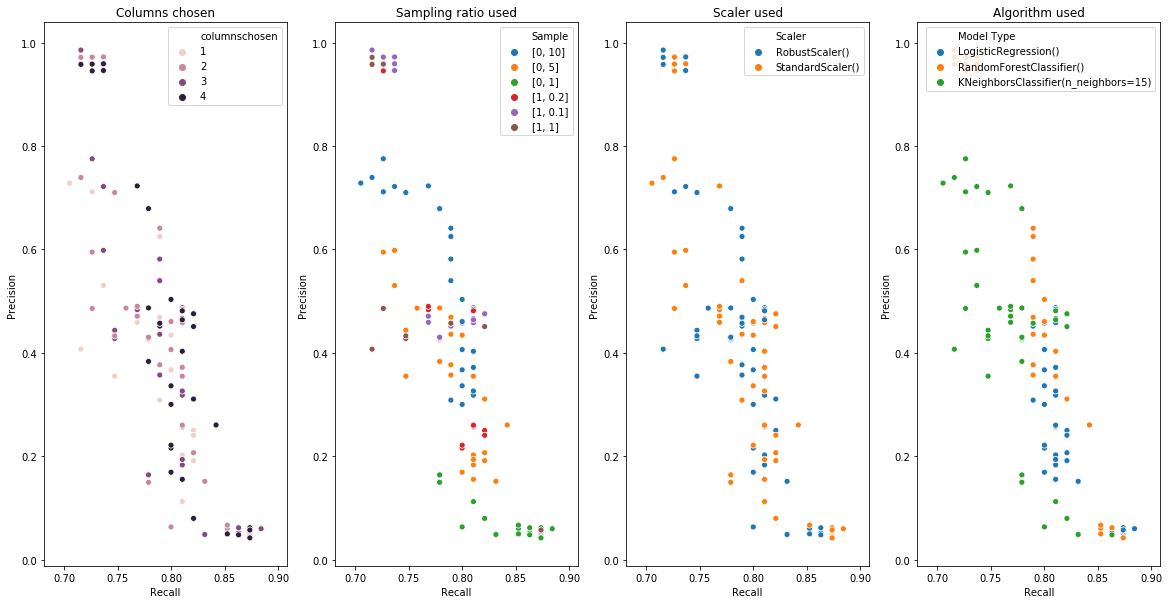

In [129]:
f, axes = plt.subplots(ncols=4, figsize=(20,10))

sns.scatterplot(x=modelresults['Recall'],y=modelresults['Precision'],hue=modelresults['columnschosen'],ax=axes[0])
axes[0].set_title('Columns chosen')

sns.scatterplot(x=modelresults['Recall'],y=modelresults['Precision'],hue=modelresults['Sample'],ax=axes[1])
axes[1].set_title('Sampling ratio used')

sns.scatterplot(x=modelresults['Recall'],y=modelresults['Precision'],hue=modelresults['Scaler'],ax=axes[2])
axes[2].set_title('Scaler used')

sns.scatterplot(x=modelresults['Recall'],y=modelresults['Precision'],hue=modelresults['Model Type'],ax=axes[3])
axes[3].set_title('Algorithm used')

plt.show()


#### Subset the models which achieve our criteria

In [130]:
modelresults[(modelresults['Recall']>0.8) & (modelresults['Specificity'] > 0.99)] 

,Columns,Sample,Scaler,Model Type,Recall,Precision,Specificity,columnschosen
6,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 5]",RobustScaler(),LogisticRegression(),0.810526,0.202632,0.994651,1
9,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 5]",StandardScaler(),LogisticRegression(),0.821053,0.191646,0.994193,1
18,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[1, 0.2]",RobustScaler(),LogisticRegression(),0.821053,0.250000,0.995869,1
21,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[1, 0.2]",StandardScaler(),LogisticRegression(),0.821053,0.240741,0.995658,1
36,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",RobustScaler(),LogisticRegression(),0.810526,0.318182,0.997087,3
39,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 10]",StandardScaler(),LogisticRegression(),0.810526,0.326271,0.997193,3
42,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 5]",RobustScaler(),LogisticRegression(),0.810526,0.183333,0.993945,3
45,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[0, 5]",StandardScaler(),LogisticRegression(),0.810526,0.193955,0.994351,3
54,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[1, 0.2]",RobustScaler(),LogisticRegression(),0.810526,0.256667,0.996064,3
57,"V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14...","[1, 0.2]",StandardScaler(),LogisticRegression(),0.810526,0.258389,0.996099,3


In [103]:
modelresults.iloc[118]['Columns']

'V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class'

The best model (although marginally) in terms of maximising recall seems to be the following.

- Random Forest
- Using reduced number of variables
- Undersampling non-fraud transactions to 5x the number of fraud transactions
- Using a standard scaler to scale the variables

In [85]:
df_chosenfeatures=df[['V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19','Amount','Class']]

X = df_chosenfeatures.drop('Class',axis=1)
y = df_chosenfeatures['Class']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df_chosenfeatures, df_chosenfeatures['Class']):
    X_strat_train_set, X_test = X.iloc[train_index], X.iloc[test_index]
    y_strat_train_set, y_test = y.iloc[train_index], y.iloc[test_index]

train_set_resampled, X_train, y_train = resample_fraud(X_strat_train_set, y_strat_train_set,0,5)

scaler=StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),columns=X_test.columns)

rfmodel=RandomForestClassifier()
rfmodel.fit(X_train_scaled, y_train)

predictions=rfmodel.predict(X_test_scaled)
display(confusion_matrix(y_test, predictions))

print(classification_report(y_test,predictions))


array([[56418,   233],
       [   16,    79]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.25      0.83      0.39        95

    accuracy                           1.00     56746
   macro avg       0.63      0.91      0.69     56746
weighted avg       1.00      1.00      1.00     56746



## Use GridSearch to tune hyperparameters

Use grid search to find the optimum hyperparameters for performance (using f1 score as our target metric to optimise and balance precision and recall)

In [108]:
from sklearn.model_selection import GridSearchCV

rfmodel = RandomForestClassifier()

param = {
    'n_estimators':[10,20,50,100],
    'criterion': ['entropy', 'gini'],
    'max_depth' :[10,15,20],
    'class_weight' :['balanced', 'balanced_subsample']
}

gridsearch_rf = GridSearchCV(rfmodel, param_grid=param, scoring='f1', cv=5, verbose=1, n_jobs=-1)

In [109]:
gridsearch_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 15, 20],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [110]:
gridsearch_rf.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 20,
 'n_estimators': 50}

In [119]:
rf_best_model= RandomForestClassifier(criterion= 'gini', 
                                    max_depth= 30,
                                    n_estimators=50,
                                    class_weight='balanced_subsample',
                                    verbose=1)
rf_best_model.fit(X_train_scaled, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       n_estimators=50, verbose=1)

In [121]:
predictions=rf_best_model.predict(X_test_scaled)
display(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

array([[56516,   135],
       [    9,    86]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.39      0.91      0.54        95

    accuracy                           1.00     56746
   macro avg       0.69      0.95      0.77     56746
weighted avg       1.00      1.00      1.00     56746

